In [1]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
import keras.backend.tensorflow_backend as tfback
from keras.constraints import max_norm
from keras import regularizers


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
import gc

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# For using tensorflow with GPU
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [ ]:
K.clear_session() # Clear previous models from memory.

PATH = os.getcwd()
data_path = PATH + '/dataset2'
data_dir_list = os.listdir(data_path)


In [4]:
num_classes = 10

labels_name= {"Ramnit" : 1, "Lollipop" : 2, "Kelihos_ver3" : 3, "Vundo" : 4, "Tracur" : 5, "Kelihos_ver1" : 6, "Obfuscator.ACY" : 7, "Gatak" : 8, "Benign" : 9}
image_list=[]
labels_list = []

training_data_path = PATH + '/dataset2/Train'
train_data_dir_list = os.listdir(training_data_path)
print(train_data_dir_list)


['Benign', 'Gatak', 'Kelihos_ver1', 'Kelihos_ver3', 'Lollipop', 'Obfuscator.ACY', 'Ramnit', 'Tracur', 'Vundo']


In [5]:
# Loading dataset 

for folders in train_data_dir_list:
    train_img_list=os.listdir(training_data_path+'/'+ folders)
    print ('Loading the images of dataset-'+'{}\n'.format(folders))
    label = labels_name[folders]
    
    for img in train_img_list:
        input_img=cv2.imread(training_data_path + '/'+ folders + '/'+ img, 0 )
        image_list.append(input_img)
        labels_list.append(label)

Loading the images of dataset-Benign

Loading the images of dataset-Gatak

Loading the images of dataset-Kelihos_ver1

Loading the images of dataset-Kelihos_ver3

Loading the images of dataset-Lollipop

Loading the images of dataset-Obfuscator.ACY

Loading the images of dataset-Ramnit

Loading the images of dataset-Tracur

Loading the images of dataset-Vundo



3941


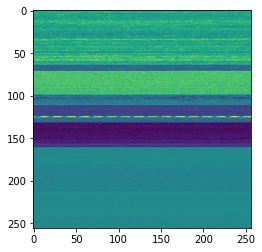

In [6]:
# Converting images to numpy array as float and plotting

images = np.array(image_list)
del image_list
images = images.astype('float32')
print(images.shape[0])
plt.imshow(np.reshape(images[1,:],(256,256)))


In [7]:
# Spliting data in train and test

labels = np.array(labels_list)
trainImages, testImages, trainLabels, testLabels = train_test_split(images, labels, test_size=0.30, random_state=12344, shuffle = True)
print(np.unique(trainLabels))
del labels_list
del images
del labels

[1 2 3 4 5 6 7 8 9]


In [3]:
# Reshaping images and converting the pixel values in terms of zero and ones using min max scaling


trainLabels = np_utils.to_categorical(trainLabels)
testLabels = np_utils.to_categorical(testLabels)
numOfClasses = testLabels.shape[1]


trainImages = trainImages.reshape(trainImages.shape[0],1, 256, 256).astype('float32')
testImages = testImages.reshape(testImages.shape[0],1, 256, 256).astype('float32')

trainImages = (trainImages-np.min(trainImages))/(np.max(trainImages)-np.min(trainImages))
testImages = (testImages-np.min(testImages))/(np.max(testImages)-np.min(testImages))

K.set_image_data_format("channels_first")


NameError: name 'np_utils' is not defined

In [9]:
# Defining Sequential Model (CNN)

model = Sequential()

## Conv layer 1
model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3), 
                 input_shape=(1, 256, 256), 
                 activation = "relu",
#                 kernel_regularizer=regularizers.l2(0.01),
                 name = "Conv1"))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2), 
                 name = "M1"))

## Conv layer 2
model.add(Conv2D(filters = 32, 
                 kernel_size=(3, 3),
                 activation = "relu", 
#                 kernel_regularizer=regularizers.l2(0.01),
                 name = "Conv2"))
model.add(Dropout(0.2))
model.add(
    MaxPooling2D(pool_size=(2, 2), 
                 name = "M2"))

## Conv layer 3
model.add(Conv2D(filters = 16, 
                 kernel_size=(3, 3),
                 activation = "relu", 
#                 kernel_regularizer=regularizers.l2(0.01),
                 name = "Conv3"))
model.add(Dropout(0.2))
model.add(
    MaxPooling2D(pool_size=(2, 2), 
                 name = "M3"))

model.add(
    Flatten(name = "Flatten"))

## Dense layer 1
model.add(
    Dense(units=64, 
          activation = "relu",
#          kernel_regularizer=regularizers.l2(0.01),
          name = 'Dense1'))

## Dense layer 2
model.add(
    Dense(units=32, 
          activation = "relu",
#          kernel_regularizer=regularizers.l2(0.01),
          name = 'Dense2'))

## Dense layer 3
model.add(
    Dense(units=numOfClasses,  
          name = 'Dense3',
          # W_regularizer=regularizers.l2(0.01),
          activation = "softmax"))

adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=0.0001, verbose=2, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 64, 254, 254)      640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 254, 254)      0         
_________________________________________________________________
M1 (MaxPooling2D)            (None, 64, 127, 127)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 125, 125)      18464     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 125, 125)      0         
_________________________________________________________________
M2 (MaxPooling2D)            (None, 32, 62, 62)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 60, 60)       

In [10]:
# Fitting the Model

history = model.fit(trainImages, trainLabels, validation_data=(testImages,testLabels), epochs=50, batch_size=32, verbose=2)

Train on 2758 samples, validate on 1183 samples
Epoch 1/50
 - 25s - loss: 1.3531 - accuracy: 0.5250 - val_loss: 1.1048 - val_accuracy: 0.7287
Epoch 2/50
 - 23s - loss: 0.7142 - accuracy: 0.7792 - val_loss: 0.8018 - val_accuracy: 0.8250
Epoch 3/50
 - 23s - loss: 0.4786 - accuracy: 0.8582 - val_loss: 0.5819 - val_accuracy: 0.8622
Epoch 4/50
 - 26s - loss: 0.3305 - accuracy: 0.8999 - val_loss: 0.4996 - val_accuracy: 0.8977
Epoch 5/50
 - 27s - loss: 0.2835 - accuracy: 0.9155 - val_loss: 0.5420 - val_accuracy: 0.8935
Epoch 6/50
 - 27s - loss: 0.1988 - accuracy: 0.9431 - val_loss: 0.4195 - val_accuracy: 0.9079
Epoch 7/50
 - 27s - loss: 0.1594 - accuracy: 0.9587 - val_loss: 0.3828 - val_accuracy: 0.9019
Epoch 8/50
 - 27s - loss: 0.1265 - accuracy: 0.9663 - val_loss: 0.3495 - val_accuracy: 0.9205
Epoch 9/50
 - 27s - loss: 0.1245 - accuracy: 0.9674 - val_loss: 0.3432 - val_accuracy: 0.9062
Epoch 10/50
 - 27s - loss: 0.0949 - accuracy: 0.9757 - val_loss: 0.3137 - val_accuracy: 0.9222
Epoch 11/50

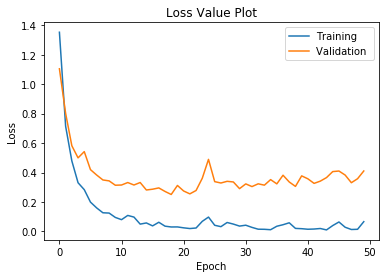

In [11]:
# Plotting Loss Plot using pyplot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Value Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation '], loc='upper right')
plt.savefig("Loss Plot.png")
plt.show()

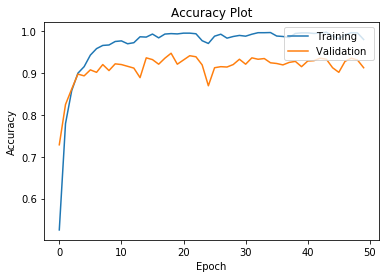

In [12]:
# Plotting Accuracy Plot using pyplot


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation '], loc='upper right')
plt.savefig("Accuracy Plot.png")
plt.show()

In [20]:
#del trainImages, testImages, trainLabels, testLabels
gc.collect()

20

In [21]:
# Saving the Model

model.save("malware-classifier.h5", include_optimizer=True)

model_json = model.to_json()
with open("malware_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

In [22]:
# Preparing Validation dataset
va_labels_name={"Ramnit" : 1, "Lollipop" : 2, "Kelihos_ver3" : 3, "Vundo" : 4, "Tracur" : 5, "Kelihos_ver1" : 6, "Obfuscator.ACY" : 7, "Gatak" : 8, "Benign" : 9}
validation_image_list=[]
validation_label_list=[]

validation_data_path = PATH + '/dataset2/Test'
validation_data_dir_list = os.listdir(validation_data_path)
print(validation_data_path)

for folders in validation_data_dir_list:
    va_img_list=os.listdir(validation_data_path+'/'+ folders)
    print ('Loading the images of dataset-'+'{}\n'.format(folders))
    label = va_labels_name[folders]

    for img in va_img_list:
        input_img=cv2.imread(validation_data_path + '/'+ folders + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        validation_image_list.append(input_img)
        validation_label_list.append(label)

C:\Users\rohan\Documents/dataset2/Test
Loading the images of dataset-Benign

Loading the images of dataset-Gatak

Loading the images of dataset-Kelihos_ver1

Loading the images of dataset-Kelihos_ver3

Loading the images of dataset-Lollipop

Loading the images of dataset-Obfuscator.ACY

Loading the images of dataset-Ramnit

Loading the images of dataset-Tracur

Loading the images of dataset-Vundo



In [24]:
# Preparing Validation dataset, reshaping images 

va_Images = np.array(validation_image_list)
va_Images = va_Images.astype('float32')

va_Labels = np.array(validation_label_list)
va_Labels = np_utils.to_categorical(va_Labels)

va_Images = va_Images.reshape(va_Images.shape[0],1, 256, 256).astype('float32')

## converting the pixel values in terms of zero and ones using min max scaling
va_Images = (va_Images-np.min(va_Images))/(np.max(va_Images)-np.min(va_Images))


[1 2 3 4 5 6 7 8 9]
(3056, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3056, 1, 256, 256)


In [25]:
# Predicting validation dataset

testPred = model.predict_classes(va_Images)
predProbabilities = model.predict(va_Images)

In [54]:
#Generating Classification Report

testLabelsOriginal = np.argmax(va_Labels, axis=1)
labels = ["Ramnit", "Lollipop", "Kelihos_ver3", "Vundo", "Tracur", "Kelihos_ver1", "Obfuscator.ACY", "Gatak", "Benign"]
print("Classification report ")
print(classification_report(y_true=testLabelsOriginal, y_pred=testPred, target_names = labels))

Classification report 
                precision    recall  f1-score   support

        Ramnit       0.72      0.74      0.73       350
      Lollipop       0.96      0.90      0.93       350
  Kelihos_ver3       1.00      1.00      1.00       350
         Vundo       0.99      0.81      0.89       245
        Tracur       0.86      0.90      0.88       251
  Kelihos_ver1       0.97      0.93      0.95       198
Obfuscator.ACY       0.87      0.91      0.89       350
         Gatak       0.89      0.97      0.93       407
        Benign       0.82      0.82      0.82       555

      accuracy                           0.88      3056
     macro avg       0.90      0.89      0.89      3056
  weighted avg       0.89      0.88      0.88      3056



In [29]:
# Generating Confusion matrix

print("Confusion matrix ")
labels = ["Ramnit", "Lollipop", "Kelihos_ver3", "Vundo", "Tracur", "Kelihos_ver1", "Obfuscator.ACY", "Gatak", "Benign"]
cm = confusion_matrix(y_true=testLabelsOriginal, y_pred=testPred)
print(cm)

Confusion matrix 
[[258   0   0   0  13   1   8   0  70]
 [  0 315   0   0   4   1   1  16  13]
 [  0   0 349   0   0   0   0   1   0]
 [ 17   0   1 199   4   2  17   4   1]
 [ 10   2   0   0 226   1   3   2   7]
 [  0   0   0   0   0 185   3  10   0]
 [ 10   4   0   1   4   0 319   3   9]
 [  2   0   0   0   2   1   5 396   1]
 [ 59   6   0   0  10   0  11  14 455]]


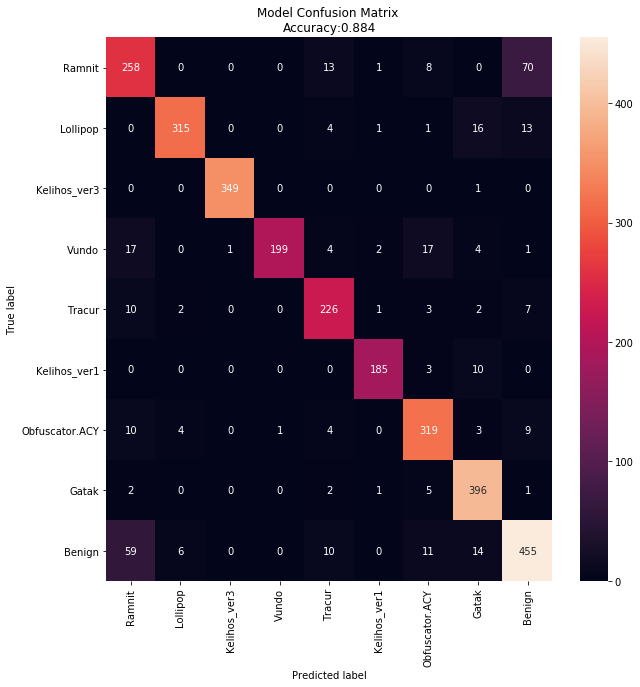

In [53]:
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["Ramnit", "Lollipop", "Kelihos_ver3", "Vundo", "Tracur", "Kelihos_ver1", "Obfuscator.ACY", "Gatak", "Benign"],
                     columns = ["Ramnit", "Lollipop", "Kelihos_ver3", "Vundo", "Tracur", "Kelihos_ver1", "Obfuscator.ACY", "Gatak", "Benign"])

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt="d")
plt.title('Model Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(testLabelsOriginal, testPred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion Plot.png")

plt.show()